In [3]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import pathlib
from google.cloud import storage
import tensorflow_hub as hub
from io import BytesIO
from tensorflow.python.lib.io import file_io
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [4]:
import random as rn
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)

# set initializer
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)

In [22]:
train_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/train_data_siebren.csv", header=None)
# train_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/train_data_siebren_under_over.csv", header=None)
val_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/val_data_siebren.csv", header=None)
test_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/test_data_siebren.csv", header=None)
CLASS_NAMES = train_data[0].unique()

In [23]:
def check_data(data):
#     no_series = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/data_without_series_250.csv")
#     z_score = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/data_without_zScore.csv")
    overexposed = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/overexposed.csv")
    underexposed = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/underexposed.csv")
    data[1] = data[1].map(lambda x: x.lstrip('../gabon-dataset/data_training_rescaled_extra/'))
    cond = data[1].isin(overexposed['overexposed'])
    cond2 = data[1].isin(underexposed['underexposed'])
    data.drop(data[cond].index, inplace = True)
    data.drop(data[cond2].index, inplace = True)
    new_data = data
#     new_data = new_data[[0, 1]]
#     new_data[1] = '../gabon-dataset/data_training_rescaled_extra/' + new_data[1]
    return new_data       

In [24]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

BATCH_SIZE = 128
# 10 is a magic number tuned for local training of this dataset.
SHUFFLE_BUFFER = 10 * BATCH_SIZE
AUTOTUNE = tf.data.experimental.AUTOTUNE

VALIDATION_IMAGES = 370
VALIDATION_STEPS = VALIDATION_IMAGES // BATCH_SIZE

In [25]:
def decode_img(img, reshape_dims):
    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the desired size.
    return tf.image.resize(img, reshape_dims)

In [26]:
MAX_DELTA = 63.0 / 255.0  # Change brightness by at most 17.7%
CONTRAST_LOWER = 0.2
CONTRAST_UPPER = 1.8

def read_and_preprocess(image_bytes, label, random_augment=False):
#     if random_augment:
#         img = decode_img(image_bytes, [IMG_HEIGHT + 10, IMG_WIDTH + 10])
#         img = tf.image.random_crop(img, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
#         img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_brightness(img, MAX_DELTA)
#         img = tf.image.random_contrast(img, CONTRAST_LOWER, CONTRAST_UPPER)
#     else:
    img = decode_img(image_bytes, [IMG_WIDTH, IMG_HEIGHT])
    return img, label


def read_and_preprocess_with_augment(image_bytes, label):
    return read_and_preprocess(image_bytes, label, random_augment=True)

In [27]:
def decode_csv(csv_row):
    record_defaults = ["img", "path"]
    label_string, filename = tf.io.decode_csv(csv_row, record_defaults)
    image_bytes = tf.io.read_file(filename=filename)
    label = tf.math.equal(CLASS_NAMES, label_string)
    return image_bytes, label

In [28]:
def load_dataset(csv_of_filenames, batch_size, training=True):    
    dataset = tf.data.TextLineDataset(filenames=csv_of_filenames) \
        .map(decode_csv, num_parallel_calls=tf.data.AUTOTUNE)
    
    if training:
        dataset = dataset \
            .map(read_and_preprocess_with_augment, num_parallel_calls=tf.data.AUTOTUNE) \
            .repeat(count=1)
        
#             .shuffle(SHUFFLE_BUFFER) \
#             .repeat(count=-1)
#             .repeat(count=None)  # Indefinately.

#         dataset = dataset \
#             .map(read_and_preprocess_with_augment) \
#             .shuffle(SHUFFLE_BUFFER) \
#             .repeat(count=None)  # Indefinately.
    else:
        dataset = dataset \
            .map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
            .repeat(count=1)  # Each photo used once.
    
    # Prefetch prepares the next set of batches while current batch is in use.
    return dataset.batch(batch_size=batch_size).prefetch(buffer_size=AUTOTUNE)
#     return dataset.range(4).interleave(lambda _: dataset.batch(batch_size=batch_size), num_parallel_calls=tf.data.AUTOTUNE )

# Model

In [29]:
# data
train_path = "gs://dataset-gabon/train_val_test_csv_Siebren/train_data_siebren.csv"
eval_path = "gs://dataset-gabon/train_val_test_csv_Siebren/val_data_siebren.csv"
nclasses = len(CLASS_NAMES)

In [30]:
base_model = keras.applications.MobileNetV2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [31]:
base_model.trainable = False

In [32]:
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(rate=0.5)(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(nclasses, activation='softmax', kernel_initializer=initializer, bias_initializer=initializer)(x)
# outputs = keras.layers.Dense(nclasses, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 28)                35868     
Total params: 2,293,852
Trainable params: 35,868
Non-trainable params: 2,257,984
_________________________________________________________________


In [34]:
# model.load_weights("gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_fine_tuned/cp.ckpt")
# model = keras.models.load_model("gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_fine_tuned/model.H5")

In [35]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

train_ds = load_dataset(train_path, BATCH_SIZE)
eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

In [36]:
# for layer in model.layers[1].layers:
#     print(layer)

In [37]:
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_fine_tuned/cp.ckpt",
#                                                  save_weights_only=True,
#                                                  verbose=1)

In [38]:
history = model.fit(train_ds,
            epochs=1,
#             steps_per_epoch=(len(train_data) // BATCH_SIZE),
            validation_data=eval_ds,
#             callbacks=[cp_callback]
#             validation_steps=(len(val_data) // BATCH_SIZE)
         )

    686/Unknown - 597s 866ms/step - loss: 1.9889 - accuracy: 0.4473

KeyboardInterrupt: 

In [ ]:
0.6996

In [ ]:
2072s 1s/step - loss: 1.6011 - accuracy: 0.5326 - val_loss: 0.9371 - val_accuracy: 0.7017

In [28]:
model.trainable = True
# BATCH_SIZE =64

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

train_ds = load_dataset(train_path, BATCH_SIZE)
eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

In [18]:
history = model.fit(train_ds,
            epochs=2,
#             steps_per_epoch=(len(train_data) // BATCH_SIZE),
            validation_data=eval_ds,
            callbacks=[cp_callback]
#             validation_steps=(len(val_data) // BATCH_SIZE)
         )

Epoch 1/2
1904/1904 [==============================] - 3317s 2s/step - loss: 0.5260 - accuracy: 0.8369 - val_loss: 0.4411 - val_accuracy: 0.8601

Epoch 00001: saving model to gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_fine_tuned/cp.ckpt
Epoch 2/2
1904/1904 [==============================] - 3328s 2s/step - loss: 0.4070 - accuracy: 0.8735 - val_loss: 0.3832 - val_accuracy: 0.8794

Epoch 00002: saving model to gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_fine_tuned/cp.ckpt


# save model

In [19]:
tf.keras.models.save_model(model, "gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_fine_tuned_3epoch/model.H5", 
                           include_optimizer=False)

INFO:tensorflow:Assets written to: gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_fine_tuned_3epoch/model.H5/assets


# Test myanmarData

In [22]:
test_data_myan = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/test_data_myanmar_siebren.csv", header=None)
test_path_myan = "gs://dataset-gabon/train_val_test_csv_Siebren/test_data_myanmar_siebren.csv"
test_ds_myan = load_dataset(test_path_myan, BATCH_SIZE, training=False)

In [18]:
test_loss, test_acc = model.evaluate(test_ds_myan, verbose=1)
print(test_acc)

476/476 [==============================] - 438s 912ms/step - loss: 0.3842 - accuracy: 0.8783
0.8793570399284363


In [27]:
PREDICTIONS = len(test_data_myan)//BATCH_SIZE
y_test = []
counter = 0
for i in tqdm(test_ds_myan):
    if counter < PREDICTIONS:
        counter += 1
        for j in i[1]:
            y_test.append(np.where(j == True)[0][0])
    else:
        break
print(len(y_test))

4it [00:26,  6.65s/it]


KeyboardInterrupt: 

In [298]:
# y_pred = model.predict(test_ds_myan, steps=PREDICTIONS)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = y_test
y, idx = tf.unique(predicted_categories)
cm = confusion_matrix(predicted_categories, true_categories, normalize="pred", labels=y.numpy())
cmn = cm
df_cm = pd.DataFrame(cmn, index = [CLASS_NAMES[i] for i in y.numpy()],
                  columns = [CLASS_NAMES[i] for i in y.numpy()])

<AxesSubplot:>

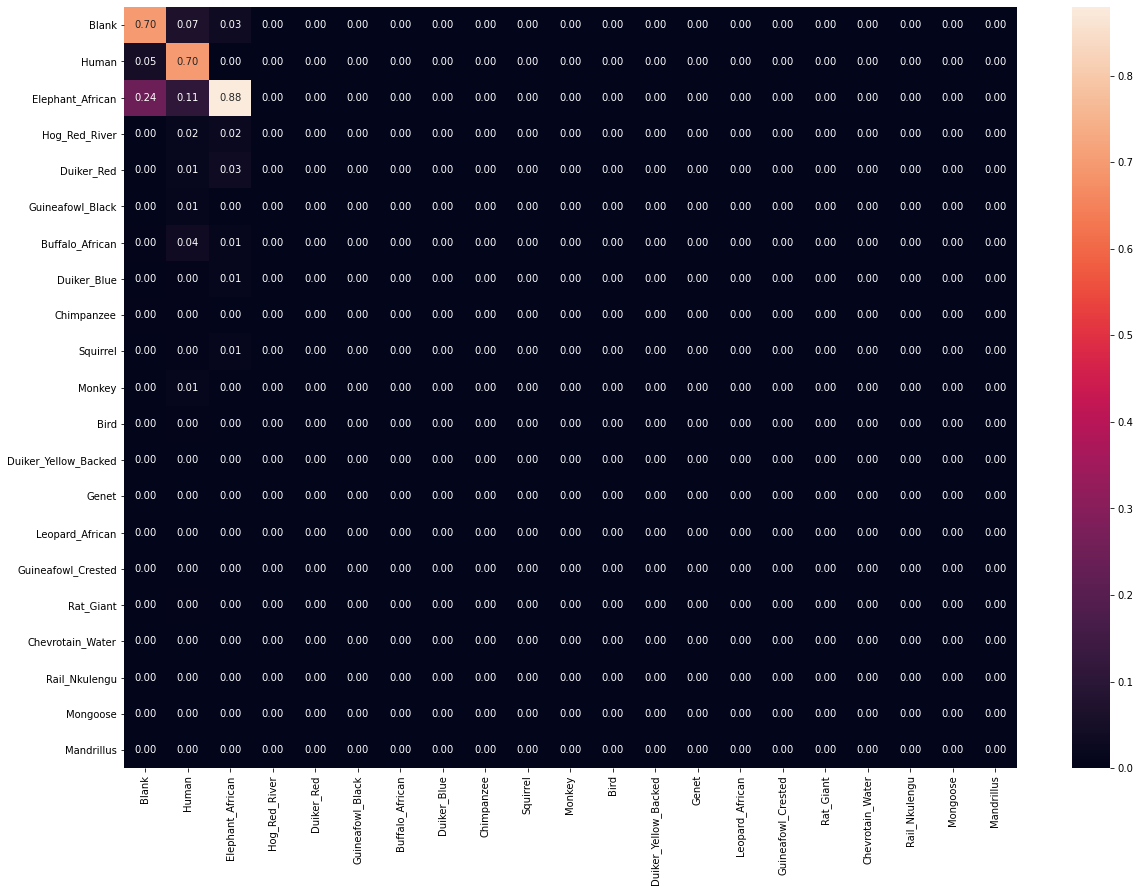

In [299]:
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True, fmt='.2f')

In [286]:
correctly_classified = {}
total = {}
for idx, i in enumerate(true_categories):
    if i == predicted_categories[idx].numpy():
        if CLASS_NAMES[i] in correctly_classified.keys():
            correctly_classified[CLASS_NAMES[i]] += 1
        else:
            correctly_classified[CLASS_NAMES[i]] = 1
    
    if CLASS_NAMES[i] in total.keys():
        total[CLASS_NAMES[i]] += 1
    else:
        total[CLASS_NAMES[i]] = 1
            
print("correct:", correctly_classified)
print("total:  ", total)

correct: {'Blank': 2386, 'Human': 3085, 'Elephant_African': 80}
total:   {'Blank': 3421, 'Human': 4424, 'Elephant_African': 91}


In [291]:
plt.ion()
index = 0
for idx, i in enumerate(test_ds_myan):   
    for j in i[0]:
#         if y_pred[index][y_pred[index].argmax()] > 0.90:
        if predicted_categories[index].numpy() != true_categories[index]:
            plt.figure(figsize = (16,16))
            plt.imshow(j)
            plt.show()
            print("Prediction: "+ str(CLASS_NAMES[predicted_categories[index].numpy()]))
            print("True: "+ str(CLASS_NAMES[true_categories[index]]))
        index+=1

KeyboardInterrupt: 

# Results

In [109]:
test_path = "gs://dataset-gabon/train_val_test_csv_Siebren/test_data_siebren.csv"
test_ds = load_dataset(test_path, BATCH_SIZE, training=False)

acc = 0.5442
acc = 0.5497

In [110]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1, steps=len(test_data)//BATCH_SIZE)
print(test_acc)

340/340 [==============================] - 146s 428ms/step - loss: 1.6574 - accuracy: 0.5497
0.5496553182601929


In [20]:
# plot results
# plt.plot(history.history['accuracy'], label='train_accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0, 1])
# plt.legend(loc='lower right')

In [21]:
# plot results
# plt.plot(history.history['loss'], label='train_loss')
# plt.plot(history.history['val_loss'], label = 'train_loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.ylim([0, 10])
# plt.legend(loc='lower right')

In [28]:
PREDICTIONS = len(test_data)//BATCH_SIZE
y_test = []
counter = 0
for i in tqdm(test_ds):
    if counter < PREDICTIONS:
        counter += 1
        for j in i[1]:
            y_test.append(np.where(j == True)[0][0])
    else:
        break
print(len(y_test))

340it [00:58,  5.79it/s]

43520


In [72]:
# y_pred = model.predict(test_ds, steps=PREDICTIONS)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = y_test
cm = confusion_matrix(predicted_categories, true_categories, normalize="all")
df_cm = pd.DataFrame(cm, index = [i for i in CLASS_NAMES],
                  columns = [i for i in CLASS_NAMES])

<AxesSubplot:>

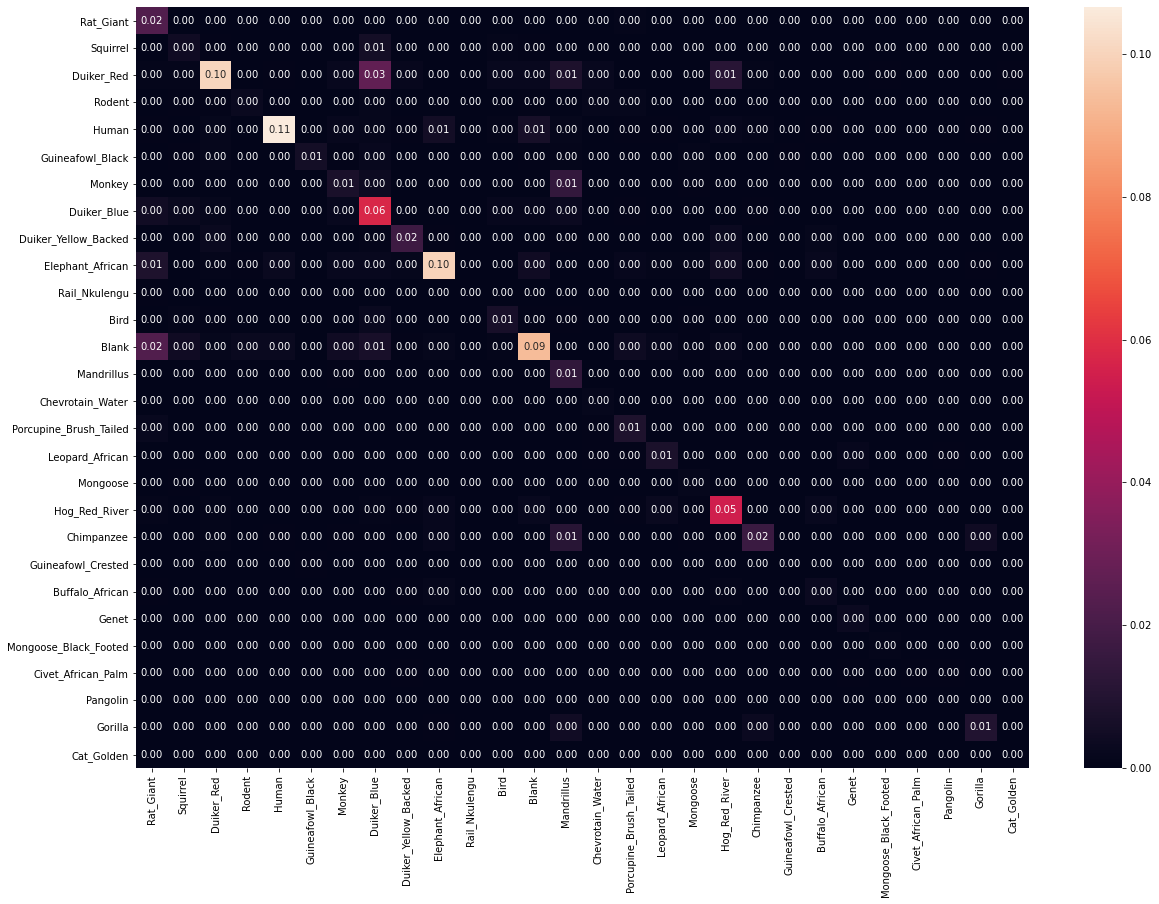

In [73]:
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True, fmt='.2f')

In [68]:
# animal = 0
# correct = 0
# total = 0
# total_neg = 0

# for idx, pred in enumerate(predicted_categories):
#     # precision
#     if pred.numpy() == animal and true_categories[idx] == animal:
#         correct += 1
#     if true_categories[idx] == animal:
#         total += 1
#     if pred.numpy() == animal:
#         total_neg += 1

# print(CLASS_NAMES[0])
# print("precision, ", correct/ total)
# print("recal, ", correct/ total_neg)

Rat_Giant
precision,  0.3437935843793584
recal,  0.9155060352831941


In [129]:
new_labels = CLASS_NAMES.copy()
report = classification_report(predicted_categories, true_categories, output_dict=True)
df = pd.DataFrame(report).transpose()
if new_labels[len(new_labels) -1] != "-":
    new_labels = np.append(new_labels, ["-", "-", "-"])
df = df.round(decimals=2)
df['label'] = new_labels
df["precision"].iloc[len(new_labels) -3] = "-"
df["recall"].iloc[len(new_labels) -3] = "-"
df["support"].iloc[len(new_labels) -3] = df["support"].iloc[len(new_labels) -2]
df

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,precision,recall,f1-score,support,label
0,0.34,0.92,0.50,1077.0,Rat_Giant
1,0.24,0.28,0.26,668.0,Squirrel
2,0.88,0.6,0.71,7247.0,Duiker_Red
3,0.33,0.26,0.29,426.0,Rodent
4,0.93,0.8,0.86,5796.0,Human
5,0.77,0.36,0.49,672.0,Guineafowl_Black
6,0.31,0.26,0.28,1168.0,Monkey
7,0.5,0.73,0.59,3464.0,Duiker_Blue
8,0.69,0.61,0.64,1240.0,Duiker_Yellow_Backed
9,0.87,0.73,0.80,5931.0,Elephant_African


In [151]:
mean_aggregated_cross_entropy_loss = {}

for idx, pred in enumerate(y_pred):
    loss = 1 - pred[true_categories[idx]]
    if CLASS_NAMES[true_categories[idx]] in mean_aggregated_cross_entropy_loss:
        mean_aggregated_cross_entropy_loss[CLASS_NAMES[true_categories[idx]]].append(loss)
    else:
        mean_aggregated_cross_entropy_loss[CLASS_NAMES[true_categories[idx]]] = [loss]

for keys, values in mean_aggregated_cross_entropy_loss.items():
    mean = sum(values)/ len(values)
    mean_aggregated_cross_entropy_loss[keys] = mean.round(2)
    
mean_aggregated_cross_entropy_loss

{'Blank': 0.23,
 'Human': 0.09,
 'Elephant_African': 0.16,
 'Leopard_African': 0.51,
 'Buffalo_African': 0.72,
 'Hog_Red_River': 0.35,
 'Duiker_Red': 0.15,
 'Civet_African_Palm': 0.67,
 'Squirrel': 0.81,
 'Monkey': 0.73,
 'Duiker_Blue': 0.55,
 'Bird': 0.59,
 'Mongoose_Black_Footed': 0.75,
 'Rodent': 0.77,
 'Duiker_Yellow_Backed': 0.35,
 'Genet': 0.62,
 'Chimpanzee': 0.43,
 'Gorilla': 0.49,
 'Mongoose': 0.84,
 'Chevrotain_Water': 0.86,
 'Porcupine_Brush_Tailed': 0.63,
 'Pangolin': 0.97,
 'Cat_Golden': 0.98,
 'Rat_Giant': 0.76,
 'Guineafowl_Crested': 0.73,
 'Guineafowl_Black': 0.28,
 'Rail_Nkulengu': 0.76,
 'Mandrillus': 0.79}

In [135]:
CLASS_NAMES

array(['Rat_Giant', 'Squirrel', 'Duiker_Red', 'Rodent', 'Human',
       'Guineafowl_Black', 'Monkey', 'Duiker_Blue',
       'Duiker_Yellow_Backed', 'Elephant_African', 'Rail_Nkulengu',
       'Bird', 'Blank', 'Mandrillus', 'Chevrotain_Water',
       'Porcupine_Brush_Tailed', 'Leopard_African', 'Mongoose',
       'Hog_Red_River', 'Chimpanzee', 'Guineafowl_Crested',
       'Buffalo_African', 'Genet', 'Mongoose_Black_Footed',
       'Civet_African_Palm', 'Pangolin', 'Gorilla', 'Cat_Golden'],
      dtype=object)

In [43]:
prediction_dict = {'Rat_Giant':[], 'Squirrel':[], 'Duiker_Red':[], 'Rodent':[], 'Human':[],
       'Guineafowl_Black':[], 'Monkey':[], 'Duiker_Blue':[],
       'Duiker_Yellow_Backed':[], 'Elephant_African':[], 'Rail_Nkulengu':[],
       'Bird':[], 'Blank':[], 'Mandrillus':[], 'Chevrotain_Water':[],
       'Porcupine_Brush_Tailed':[], 'Leopard_African':[], 'Mongoose':[],
       'Hog_Red_River':[], 'Chimpanzee':[], 'Guineafowl_Crested':[],
       'Buffalo_African':[], 'Genet':[], 'Mongoose_Black_Footed':[],
       'Civet_African_Palm':[], 'Pangolin':[], 'Gorilla':[], 'Cat_Golden':[]}
index = 0
counter = 0
for idx, i in enumerate(tqdm(test_ds)):
    if counter < PREDICTIONS:
        counter+=1
        for j in i[0]:
            if predicted_categories[index].numpy() != true_categories[index]:
                prediction_dict[CLASS_NAMES[true_categories[index]]].append(predicted_categories[index].numpy())
            index+=1

341it [01:03,  5.34it/s]


In [44]:
for true_classes in prediction_dict.keys():
    classes = []
    for i in range(len(CLASS_NAMES)):
        counter = 0
        for j in prediction_dict[true_classes]:
            if j == i:
                counter +=1
        classes.append(counter)
    prediction_dict[true_classes] = classes

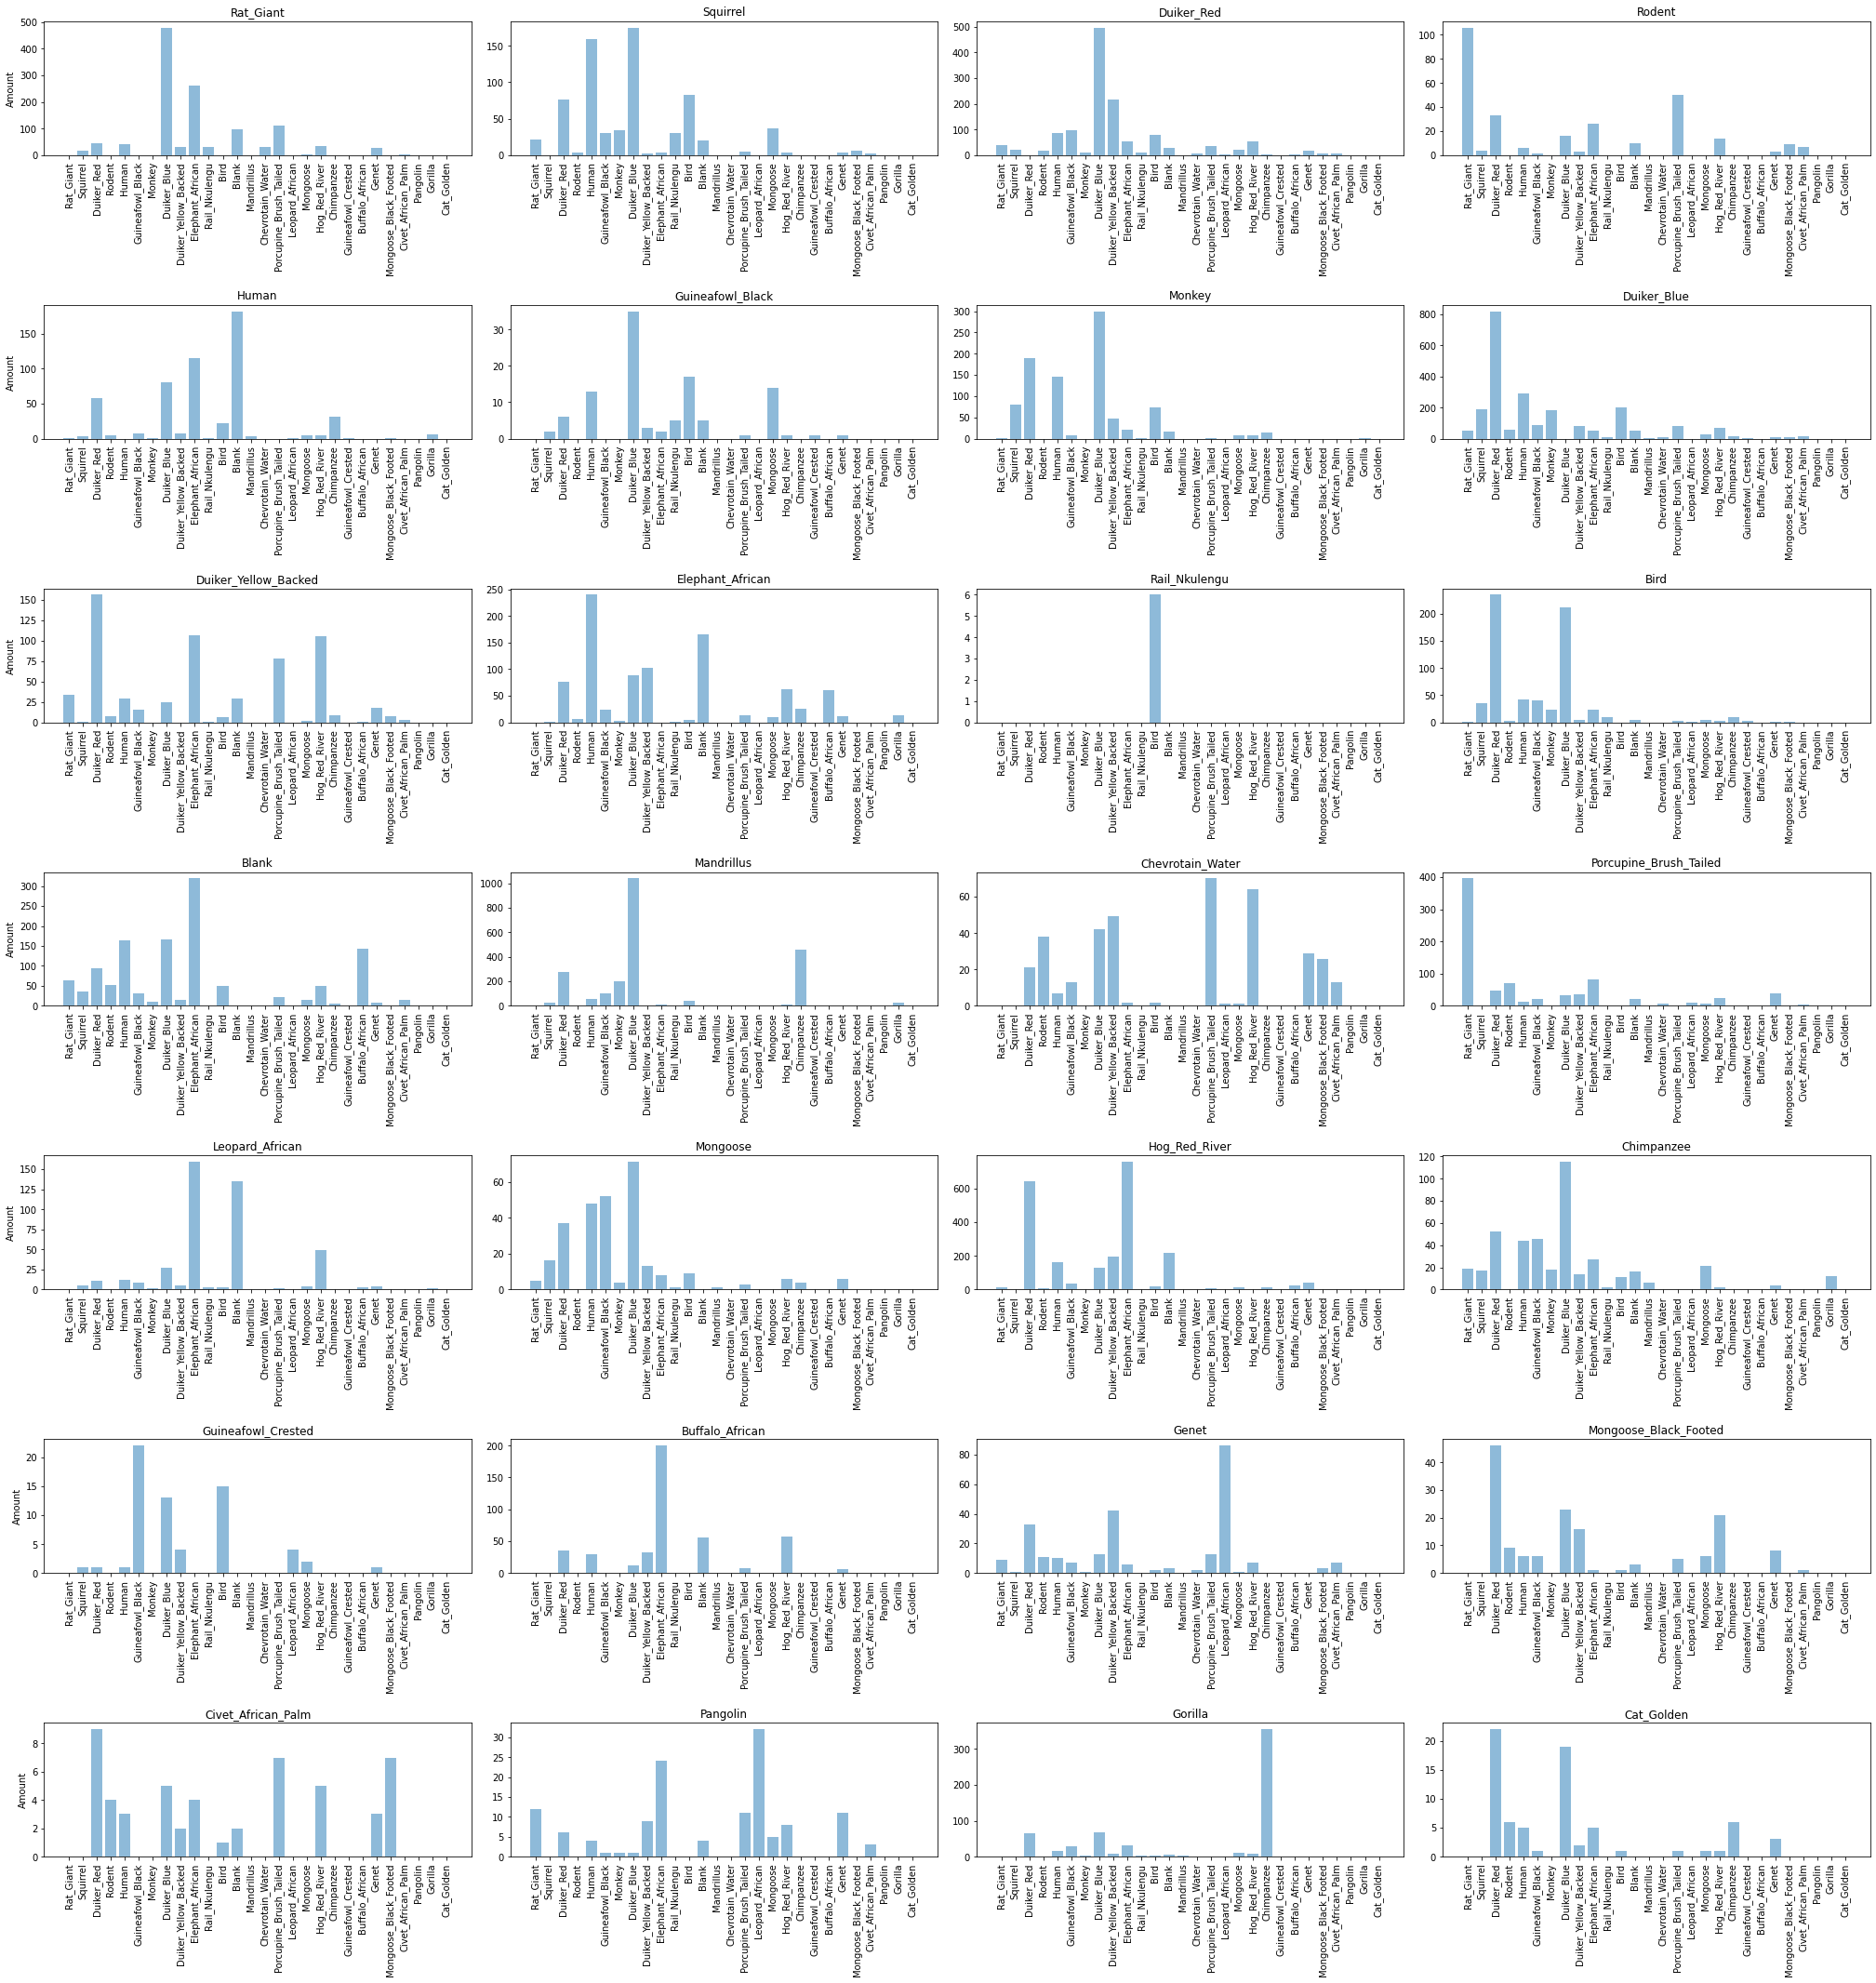

In [45]:
y_pos = np.arange(len(CLASS_NAMES))
f, axarr = plt.subplots(7,4, figsize=(28,28))
f.tight_layout(h_pad=14)

col = 0
row = 0
for name in prediction_dict.keys():
    if col < 4:
        axarr[row][col].bar(y_pos, prediction_dict[name], align='center', alpha=0.5, tick_label=CLASS_NAMES)
        axarr[row][col].set_title(name)
        axarr[row][col].set_xticklabels(CLASS_NAMES, rotation=90)
        axarr[row][0].set_ylabel('Amount')
        col += 1
    else:
        row += 1
        col = 0
        axarr[row][col].bar(y_pos, prediction_dict[name], align='center', alpha=0.5, tick_label=CLASS_NAMES)
        axarr[row][col].set_title(name)
        axarr[row][col].set_xticklabels(CLASS_NAMES, rotation=90)
        axarr[row][0].set_ylabel('Amount')
        col += 1
        
        

In [46]:
train_data.groupby(0).nunique()

,1
0,
Bird,4742
Blank,23956
Buffalo_African,4826
Cat_Golden,276
Chevrotain_Water,3461
Chimpanzee,4133
Civet_African_Palm,716
Duiker_Blue,23997
Duiker_Red,23945


In [128]:
# plt.ion()
# index = 0
# for idx, i in enumerate(test_ds):   
#     for j in i[0]:
# #         if y_pred[index][y_pred[index].argmax()] > 0.90:
#         if predicted_categories[index].numpy() != true_categories[index]:
#             plt.figure(figsize = (16,16))
#             plt.imshow(j)
#             plt.show()
#             print("Prediction: "+ str(CLASS_NAMES[predicted_categories[index].numpy()]))
#             print("True: "+ str(CLASS_NAMES[true_categories[index]]))
#         index+=1

# Saves

FileNotFoundError: [Errno 2] No such file or directory: 'gs://dataset-gabon/train_val_test_csv_Siebren/Confusion_matrix/MobileNetV2_5epoch_0.719acc.png'

# Results

MobileNetV2 | 3 epochs training | test acc 0.713 | batch size 128 |

In [ ]:
MobileNetV2 | 5 epochs training | test acc 0.719 | batch size 128 |

In [ ]:
Xception    | 3 epochs training | val acc 0.754  | batch size 128 |

In [ ]:
Xception    | 5 epochs training | val acc 0.761  | batch size 128 |

In [ ]:
Xception    | 5+1 epochs training | val acc 0.765  | batch size 128 |